In [2]:
%load_ext autoreload
%load_ext notexbook
%autoreload 2
%load_ext autotime

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm
import networkx as nx

plt.style.use("../config/custom_plt.mplstyle")

colors = [
    "#7494d3",
    "#5cb545",
    "#9956c6",
    "#a7b338",
    "#6a6bc6",
    "#d09e40",
    "#ce62bb",
    "#56be85",
    "#d1477d",
    "#397f4d",
    "#cf4b4a",
    "#40bbc1",
    "#d8662c",
    "#99af66",
    "#b76989",
    "#6d7127",
    "#b6744a"
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The notexbook extension is already loaded. To reload it, use:
  %reload_ext notexbook
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.97 ms (started: 2023-03-28 13:08:07 +02:00)


In [3]:
# %texify --code-font-family Monaco --linespread 1.2 --code-font-size 13

time: 348 µs (started: 2023-03-28 13:08:07 +02:00)


- 1  --  citeseer
- 2  --  cora
- 3  --  film
- 4  --  dblp
- 5  --  imdb
- ?  --  acm [x]
- 6  --  amazon_photo
- 7  --  cornell
- 8  --  wisconsin
- 9  --  texas
- 10  --  lastfm
- ?  --  twitch_ru [x]
- 11  --  twitch_ptbr
- 12  --  twitch_fr
- 13  --  twitch_es
- 14  --  twitch_engb
- ?  --  twitch_de [x]

In [4]:
from numba import jit

@jit(nopython=True)
def angular_distance_matrix(pos):
    distances = []
    for p1 in pos:
        for p2 in pos:
            distances.append(np.arccos(np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))))
    distances = np.array(distances).reshape((pos.shape[0], pos.shape[0]))
    return distances

time: 558 ms (started: 2023-03-28 13:08:07 +02:00)


In [5]:
from sklearn.preprocessing import LabelEncoder
import networkx.algorithms.community as nx_comm
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


def load_results(inf_coords_path, labels, g, find_labels_clustering=False):
    inf_coords = pd.read_csv(inf_coords_path, comment="#", header=None, sep="\s+")
    inf_coords.columns = ['index', 'kappa', 'hyp_rad', 'p1', 'p2', 'p3']
    inf_coords['index'] = inf_coords['index'].astype(str)
    inf_coords = inf_coords.merge(labels, on="index")
    le = LabelEncoder()
    inf_coords['encoded_label'] = le.fit_transform(inf_coords['label'])
    inf_coords = inf_coords.drop_duplicates(subset=['index'])
        
    # Louvain communities
    communities = nx_comm.louvain_communities(g, seed=123)
    communities_dict = []
    for i, com in enumerate(communities):
        communities_dict.append({c:i for c in com})

    result = {}
    for d in communities_dict:
        result.update(d)

    communities_louvain = pd.DataFrame()
    communities_louvain['index'] = result.keys()
    communities_louvain['label_louvain'] = result.values()

    inf_coords = inf_coords.merge(communities_louvain, on='index')        
    print('Number of communities from Louvain: ', len(np.unique(inf_coords['label_louvain'])))
    
    if find_labels_clustering:
        angles = angular_distance_matrix(inf_coords[['p1', 'p2', 'p3']].values)
        angles = np.nan_to_num(angles)
        angles = np.array(angles)

        # Try to find the optimal number of labels using silhouette score
        n_clusters = list(range(2, 40))
        scores = []
        for k in tqdm(n_clusters):
            clustering = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='average')
            clustering.fit(angles)
            scores.append(silhouette_score(angles, clustering.labels_))

        best_k = n_clusters[np.argmax(scores)]
        print('Number of communities from Agglomerative Clustering: ', best_k)
        clustering = AgglomerativeClustering(n_clusters=best_k, affinity='precomputed', linkage='average')
        clustering.fit(angles)
        inf_coords['label_clustering_find_k'] = clustering.labels_

        # Use the number of labels from the data
        clustering = AgglomerativeClustering(n_clusters=len(np.unique(inf_coords['label'])), 
                                             metric='precomputed', linkage='average')
        clustering.fit(angles)
        inf_coords['label_clustering_fixed_k'] = clustering.labels_

    return inf_coords

time: 175 ms (started: 2023-03-28 13:08:08 +02:00)


In [6]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def compute_nmi(y_true, y_pred):
    return metrics.cluster.normalized_mutual_info_score(y_true, y_pred)

time: 1.99 ms (started: 2023-03-28 13:08:08 +02:00)


In [7]:
def create_label_overlapping_matrix(df):
    mat_nmi = np.zeros((4, 4))
    mat_purity = np.zeros((4, 4))
    
    # 1 - true label
    # 2 - Louvain label
    # 3 - UMAP labels (the number of clusters was found using silhouette score)
    # 4 - UMAP labels (with the same number of clusters as in data)

    mat_nmi[0, 1] = compute_nmi(df['encoded_label'], df['label_louvain'])
    mat_nmi[0, 2] = compute_nmi(df['encoded_label'], df['label_clustering_find_k'])
    mat_nmi[0, 3] = compute_nmi(df['encoded_label'], df['label_clustering_fixed_k'])
    mat_nmi[1, 2] = compute_nmi(df['label_louvain'], df['label_clustering_find_k'])
    mat_nmi[1, 3] = compute_nmi(df['label_louvain'], df['label_clustering_fixed_k'])
    mat_nmi[2, 3] = compute_nmi(df['label_clustering_find_k'], df['label_clustering_fixed_k'])

    
    mat_purity[0, 1] = purity_score(df['encoded_label'], df['label_louvain'])
    mat_purity[0, 2] = purity_score(df['encoded_label'], df['label_clustering_find_k'])
    mat_purity[0, 3] = purity_score(df['encoded_label'], df['label_clustering_fixed_k'])
    mat_purity[1, 2] = purity_score(df['label_louvain'], df['label_clustering_find_k'])
    mat_purity[1, 3] = purity_score(df['label_louvain'], df['label_clustering_fixed_k'])
    mat_purity[2, 3] = purity_score(df['label_clustering_find_k'], df['label_clustering_fixed_k'])

    return mat_nmi, mat_purity


def plot_overlapping_heatmap(df, title):
    m1, m2 = create_label_overlapping_matrix(df)
    ax = sns.heatmap(m1 + m2.T, annot=True, fmt=".3f", vmax=1, vmin=0, annot_kws={"size": 16},
                linewidth=0.1, cmap='cividis')
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    ax.set_yticks([0.5, 1.5, 2.5, 3.5], 
                  [f"Data ({len(np.unique(df['label']))})", 
                   f"Louvain ({len(np.unique(df['label_louvain']))})", 
                   f"UMAP ({len(np.unique(df['label_clustering_find_k']))})",
                   f"UMAP ({len(np.unique(df['label_clustering_fixed_k']))})"],
                 rotation=0)

    ax.set_xticks([0.5, 1.5, 2.5, 3.5], 
                  [f"Data ({len(np.unique(df['label']))})", 
                   f"Louvain ({len(np.unique(df['label_louvain']))})", 
                   f"UMAP ({len(np.unique(df['label_clustering_find_k']))})",
                   f"UMAP ({len(np.unique(df['label_clustering_fixed_k']))})"],
                 rotation=20)
    # The number of clusters is shown in brackets
    
    ax.get_children()[1].update_from(ax.text(0.5, 0.5, ''))
    ax.text(0.1, 0.3, r'NMI $\rightarrow$', bbox=dict(color='white', alpha=0.9), fontsize=18)
    ax.text(0.1, 0.75, r'Purity $\downarrow$', bbox=dict(color='white', alpha=0.9), fontsize=18)
    ax.set_title(rf'\textbf{{{title}}}', fontsize=23)

time: 2.88 ms (started: 2023-03-28 13:08:08 +02:00)


In [8]:
citeseer_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer_GC_fixed.edge")
citeseer_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer.content", header=None, sep="\s+", low_memory=False)
citeseer_labels = pd.DataFrame()
citeseer_labels['index'] = citeseer_features.iloc[:, 0].astype(str)
citeseer_labels['label'] = citeseer_features.iloc[:, -1]

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap"
citeseer_only_umap = load_results(f"{base_path}/only_umap/citeseer_GC_fixed.inf_coord", citeseer_labels, citeseer_graph,
                                  find_labels_clustering=True)

Number of communities from Louvain:  37


/tmp/ipykernel_2151514/159082270.py:8: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  distances.append(np.arccos(np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))))
/tmp/ipykernel_2151514/159082270.py:8: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  distances.append(np.arccos(np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))))
  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  3%|▎         | 1/38 [00:00<00:13,  2.75it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` ins

 76%|███████▋  | 29/38 [00:09<00:02,  3.69it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 79%|███████▉  | 30/38 [00:09<00:02,  3.45it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 82%|████████▏ | 31/38 [00:09<00:02,  3.34it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 84%|████████▍ | 32/38 [00:09<00:01,  3.58it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will b

Number of communities from Agglomerative Clustering:  38
time: 15.9 s (started: 2023-03-28 13:08:09 +02:00)



/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [9]:
cora_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/cora_GC.edge")
cora_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/cora.content", header=None, sep="\s+", low_memory=False)
cora_labels = pd.DataFrame()
cora_labels['index'] = cora_features.iloc[:, 0].astype(str)
cora_labels['label'] = cora_features.iloc[:, -1]

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/"
cora_only_umap = load_results(f"{base_path}/only_umap/cora_GC.inf_coord", cora_labels, cora_graph,
                              find_labels_clustering=True)

Number of communities from Louvain:  27


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  3%|▎         | 1/38 [00:00<00:15,  2.37it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  5%|▌         | 2/38 [00:01<00:19,  1.82it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  8%|▊         | 3/38 [00:15<03:58,  6.80s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in

 82%|████████▏ | 31/38 [00:32<00:03,  1.82it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 84%|████████▍ | 32/38 [00:32<00:03,  1.59it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 87%|████████▋ | 33/38 [00:33<00:03,  1.62it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 89%|████████▉ | 34/38 [00:34<00:02,  1.59it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will b

Number of communities from Agglomerative Clustering:  39
time: 41.6 s (started: 2023-03-28 13:08:25 +02:00)


In [10]:
film_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/film/out1_graph_edges.edge")
film_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/film/out1_node_feature_label.txt", sep="\s+")
film_labels = pd.DataFrame()
film_labels['index'] = film_features['node_id'].astype(str)
film_labels['label'] = film_features['label']

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/film/umap/"
film_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", film_labels, film_graph,
                              find_labels_clustering=True)

Number of communities from Louvain:  35


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  3%|▎         | 1/38 [00:21<13:04, 21.22s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  5%|▌         | 2/38 [00:57<17:56, 29.89s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  8%|▊         | 3/38 [01:18<15:13, 26.11s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in

 82%|████████▏ | 31/38 [16:23<03:45, 32.28s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 84%|████████▍ | 32/38 [16:41<02:47, 27.94s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 87%|████████▋ | 33/38 [17:07<02:15, 27.19s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 89%|████████▉ | 34/38 [17:24<01:36, 24.13s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will b

Number of communities from Agglomerative Clustering:  38
time: 20min 56s (started: 2023-03-28 13:09:06 +02:00)


In [11]:
dblp_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/dblp_pprefp/eS1/dblp_pprefp_GC.edge")
dblp_labels = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/dblp_label.txt")
dblp_labels = np.argmax(dblp_labels, axis=1)
dblp_labels_dict = pd.DataFrame()
dblp_labels_dict['label'] = dblp_labels
dblp_labels_dict = dblp_labels_dict.reset_index()
dblp_labels_dict['index'] = dblp_labels_dict['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/"
dblp_only_umap = load_results(f"{base_path}/only_umap/dblp_pprefp_GC.inf_coord", dblp_labels_dict, dblp_graph,
                              find_labels_clustering=True)

Number of communities from Louvain:  18


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  3%|▎         | 1/38 [00:00<00:17,  2.08it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  5%|▌         | 2/38 [00:00<00:16,  2.19it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  8%|▊         | 3/38 [00:01<00:15,  2.21it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in

 82%|████████▏ | 31/38 [00:14<00:03,  2.11it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 84%|████████▍ | 32/38 [00:14<00:02,  2.12it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 87%|████████▋ | 33/38 [00:15<00:02,  2.12it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 89%|████████▉ | 34/38 [00:15<00:01,  2.13it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will b

Number of communities from Agglomerative Clustering:  2
time: 22.3 s (started: 2023-03-28 13:30:03 +02:00)


In [12]:
imdb_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/imdb_mam/eS1/imdb_mam_GC.edge")
imdb_labels = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/imdb_label.txt")
imdb_labels = np.argmax(imdb_labels, axis=1)
imdb_labels_dict = pd.DataFrame()
imdb_labels_dict['label'] = imdb_labels
imdb_labels_dict = imdb_labels_dict.reset_index()
imdb_labels_dict['index'] = imdb_labels_dict['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/"
imdb_only_umap = load_results(f"{base_path}/only_umap/imdb_mam_GC.inf_coord", imdb_labels_dict, imdb_graph,
                              find_labels_clustering=True)

Number of communities from Louvain:  27


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  3%|▎         | 1/38 [00:00<00:27,  1.33it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  5%|▌         | 2/38 [00:06<02:14,  3.74s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  8%|▊         | 3/38 [00:07<01:23,  2.40s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in

 82%|████████▏ | 31/38 [00:34<00:05,  1.18it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 84%|████████▍ | 32/38 [00:35<00:04,  1.24it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 87%|████████▋ | 33/38 [00:36<00:04,  1.21it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 89%|████████▉ | 34/38 [00:37<00:03,  1.19it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will b

Number of communities from Agglomerative Clustering:  39
time: 47.3 s (started: 2023-03-28 13:30:25 +02:00)


In [13]:
amazon_photo_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/amazon_photo_GC.edge")
amazon_photo_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/amazon_photo_labels.txt", header=None)
amazon_photo_labels.reset_index(inplace=True)
amazon_photo_labels.columns = ['index', 'label']
amazon_photo_labels['index'] = amazon_photo_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/"
amazon_photo_only_umap = load_results(f"{base_path}/only_umap/amazon_photo_GC.inf_coord", amazon_photo_labels, amazon_photo_graph,
                                      find_labels_clustering=True)

Number of communities from Louvain:  14


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  3%|▎         | 1/38 [00:27<17:03, 27.65s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  5%|▌         | 2/38 [00:47<13:43, 22.86s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  8%|▊         | 3/38 [01:09<13:18, 22.81s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in

 82%|████████▏ | 31/38 [11:47<01:43, 14.72s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 84%|████████▍ | 32/38 [11:58<01:20, 13.46s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 87%|████████▋ | 33/38 [12:22<01:23, 16.74s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 89%|████████▉ | 34/38 [12:35<01:01, 15.45s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will b

Number of communities from Agglomerative Clustering:  11
time: 14min 51s (started: 2023-03-28 13:31:13 +02:00)


In [14]:
cornell_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/out1_graph_edges.edge")
cornell_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/out1_node_feature_label.txt", sep="\s+")
cornell_labels = pd.DataFrame()
cornell_labels['index'] = cornell_features['node_id']
cornell_labels['label'] = cornell_features['label']
cornell_labels['index'] = cornell_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/"
cornell_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", cornell_labels, cornell_graph,
                                 find_labels_clustering=True)

Number of communities from Louvain:  14


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWar

Number of communities from Agglomerative Clustering:  34
time: 221 ms (started: 2023-03-28 13:46:05 +02:00)



/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [15]:
wisconsin_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/out1_graph_edges.edge")
wisconsin_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/out1_node_feature_label.txt", sep="\s+")
wisconsin_labels = pd.DataFrame()
wisconsin_labels['index'] = wisconsin_features['node_id']
wisconsin_labels['label'] = wisconsin_features['label']
wisconsin_labels['index'] = wisconsin_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/"
wisconsin_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", wisconsin_labels, wisconsin_graph,
                                   find_labels_clustering=True)

Number of communities from Louvain:  12


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWar

100%|██████████| 38/38 [00:00<00:00, 176.23it/s]

Number of communities from Agglomerative Clustering:  39
time: 307 ms (started: 2023-03-28 13:46:05 +02:00)



/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [16]:
texas_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/out1_graph_edges.edge")
texas_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/out1_node_feature_label.txt", sep="\s+")
texas_labels = pd.DataFrame()
texas_labels['index'] = texas_features['node_id']
texas_labels['label'] = texas_features['label']
texas_labels['index'] = texas_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/"
texas_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", texas_labels, texas_graph,
                               find_labels_clustering=True)

Number of communities from Louvain:  12


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWar

Number of communities from Agglomerative Clustering:  39
time: 214 ms (started: 2023-03-28 13:46:05 +02:00)



/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [17]:
lastfm_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/lastfm_asia_edges/eS1/lastfm_asia_edges.edge")
lastfm_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/lastfm_asia_target.csv")
lastfm_labels.columns = ['index', 'label']
lastfm_labels['index'] = lastfm_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/"
lastfm_only_umap = load_results(f"{base_path}/only_umap/lastfm_asia_edges.inf_coord", lastfm_labels, lastfm_graph,
                                find_labels_clustering=True)

Number of communities from Louvain:  29


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  3%|▎         | 1/38 [00:52<32:25, 52.57s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  5%|▌         | 2/38 [01:17<21:57, 36.60s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  8%|▊         | 3/38 [01:27<14:00, 24.00s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in

 82%|████████▏ | 31/38 [07:35<01:21, 11.65s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 84%|████████▍ | 32/38 [08:05<01:43, 17.25s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 87%|████████▋ | 33/38 [08:26<01:31, 18.29s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 89%|████████▉ | 34/38 [08:36<01:03, 15.90s/it]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will b

Number of communities from Agglomerative Clustering:  18
time: 10min 51s (started: 2023-03-28 13:46:05 +02:00)


In [18]:
twitch_ptbr_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/musae_PTBR_edges.edge")
twitch_ptbr_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/musae_PTBR_target.csv")
twitch_ptbr_labels['label'] = twitch_ptbr_labels['mature'].astype(int)
twitch_ptbr_labels = twitch_ptbr_labels[['new_id', 'label']]
twitch_ptbr_labels['index'] = twitch_ptbr_labels['new_id']
twitch_ptbr_labels.insert(0, 'index', twitch_ptbr_labels.pop('index'))
twitch_ptbr_labels['index'] = twitch_ptbr_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/"
twitch_ptbr_only_umap = load_results(f"{base_path}/only_umap/musae_PTBR_edges.inf_coord", twitch_ptbr_labels, twitch_ptbr_graph,
                                     find_labels_clustering=True)

Number of communities from Louvain:  8


  0%|          | 0/38 [00:00<?, ?it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  3%|▎         | 1/38 [00:00<00:05,  6.18it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  5%|▌         | 2/38 [00:00<00:05,  6.11it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
  8%|▊         | 3/38 [00:00<00:05,  6.15it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in

 82%|████████▏ | 31/38 [00:05<00:01,  6.02it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 84%|████████▍ | 32/38 [00:05<00:00,  6.10it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 87%|████████▋ | 33/38 [00:05<00:00,  5.94it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 89%|████████▉ | 34/38 [00:05<00:00,  6.06it/s]/home/rob/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will b

Number of communities from Agglomerative Clustering:  39
time: 8.58 s (started: 2023-03-28 13:56:57 +02:00)


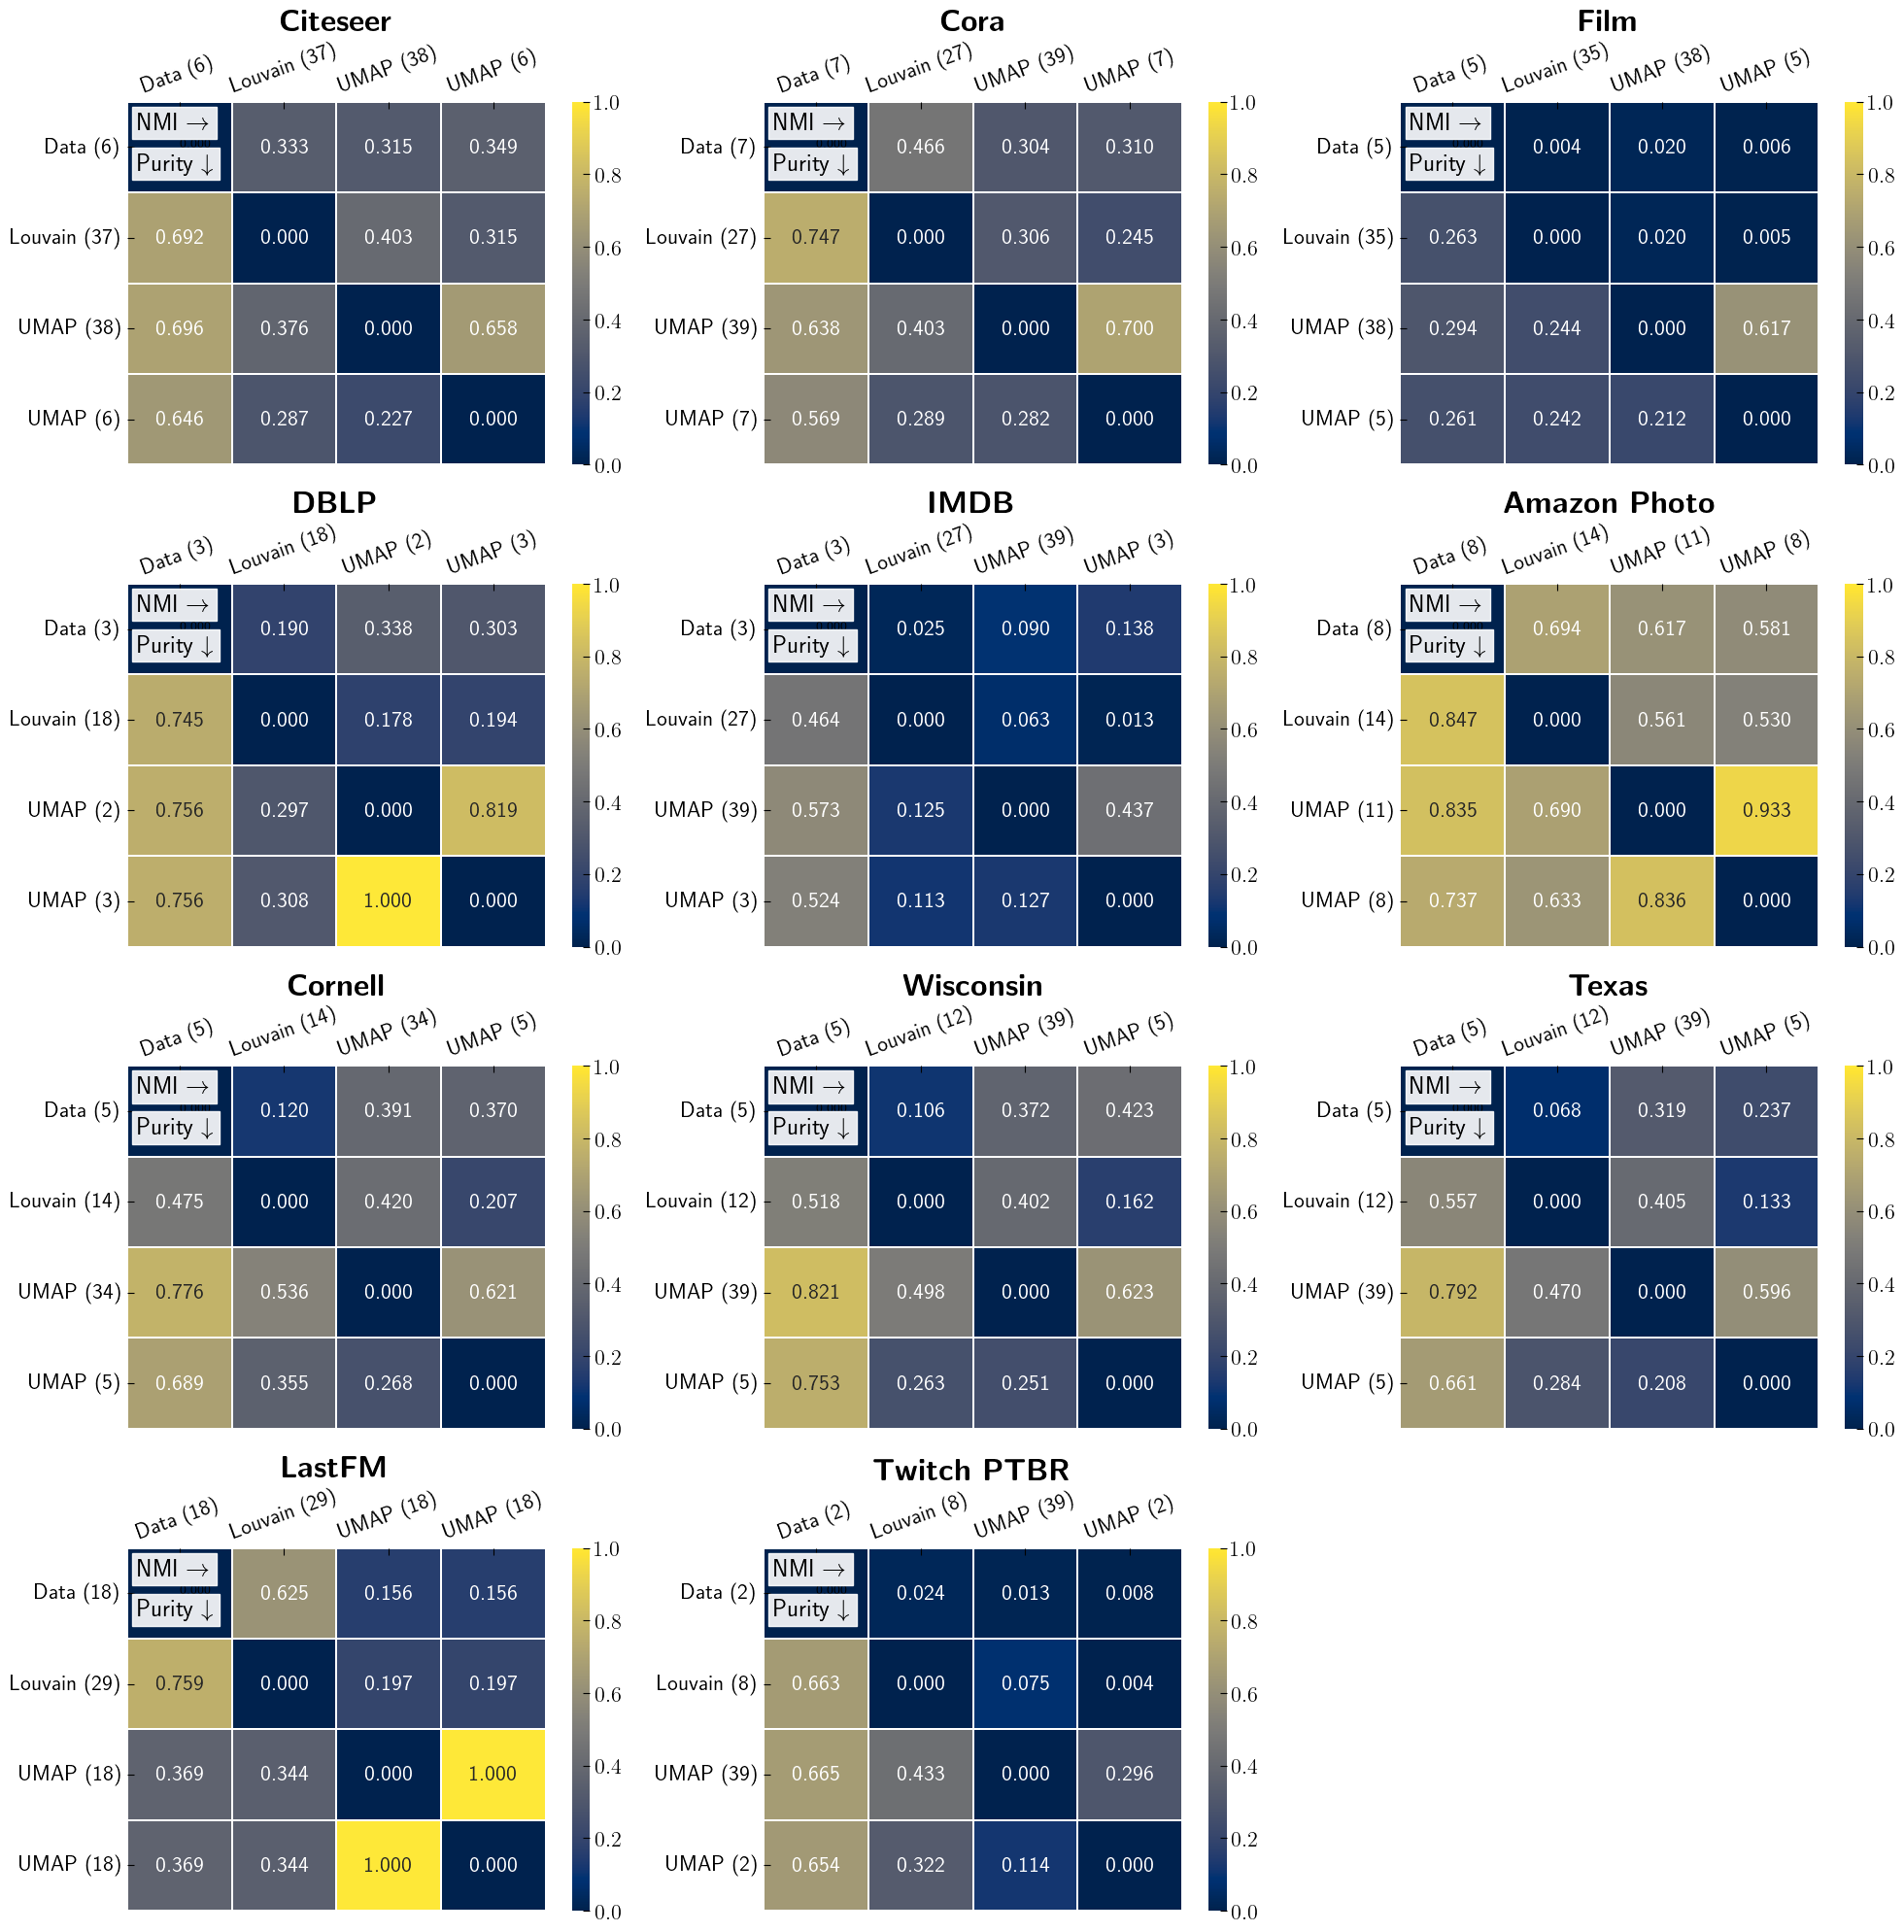

time: 7.94 s (started: 2023-03-28 16:59:51 +02:00)


In [21]:
plt.figure(figsize=(20, 20))
plt.subplot(4, 3, 1)
plot_overlapping_heatmap(citeseer_only_umap, 'Citeseer')

plt.subplot(4, 3, 2)
plot_overlapping_heatmap(cora_only_umap, 'Cora')

plt.subplot(4, 3, 3)
plot_overlapping_heatmap(film_only_umap, 'Film')

plt.subplot(4, 3, 4)
plot_overlapping_heatmap(dblp_only_umap, 'DBLP')

plt.subplot(4, 3, 5)
plot_overlapping_heatmap(imdb_only_umap, 'IMDB')

plt.subplot(4, 3, 6)
plot_overlapping_heatmap(amazon_photo_only_umap, 'Amazon Photo')

plt.subplot(4, 3, 7)
plot_overlapping_heatmap(cornell_only_umap, 'Cornell')

plt.subplot(4, 3, 8)
plot_overlapping_heatmap(wisconsin_only_umap, 'Wisconsin')

plt.subplot(4, 3, 9)
plot_overlapping_heatmap(texas_only_umap, 'Texas')

plt.subplot(4, 3, 10)
plot_overlapping_heatmap(lastfm_only_umap, 'LastFM')

plt.subplot(4, 3, 11)
plot_overlapping_heatmap(twitch_ptbr_only_umap, 'Twitch PTBR')

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/node-classification-different-type-of-labels-28-03-23/plots/community_overlap_different_methods.pdf")

In [110]:
compute_nmi(cornell_only_umap['label'], cornell_only_umap['label_clustering_find_k'])

0.39129389013341814

time: 18.6 ms (started: 2023-03-29 14:10:01 +02:00)


In [26]:
# citeseer_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer_labels_umap_find_k.csv", index=False)
# cora_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora_labels_umap_find_k.csv", index=False)
# film_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/film_labels_umap_find_k.csv", index=False)
# dblp_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp_labels_umap_find_k.csv", index=False)
# imdb_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb_labels_umap_find_k.csv", index=False)
# amazon_photo_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo_labels_umap_find_k.csv", index=False)
# cornell_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cornell_labels_umap_find_k.csv", index=False)
# wisconsin_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/wisconsin_labels_umap_find_k.csv", index=False)
# texas_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/texas_labels_umap_find_k.csv", index=False)
# lastfm_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_labels_umap_find_k.csv", index=False)
# twitch_ptbr_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch_ptbr_labels_umap_find_k.csv", index=False)

time: 59.8 ms (started: 2023-03-28 17:06:26 +02:00)


## Results of node classification on different labels

In [43]:
import pickle

datasets = ['Citeseer', 'Cora', 'Film', 'DBLP', 'IMDB', 'Amazon Photo',
            'Cornell', 'Wisconsin', 'Texas', 'LastFM', 'Twitch PTBR']

# True labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_true_labels.dat", 'rb') as f:
    nc_true_labels_le_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_true_labels.dat", 'rb') as f:
    nc_true_labels_umap_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_true_labels.dat", 'rb') as f:
    nc_true_labels_only_umap = pickle.load(f)

nc_true_labels = [nc_true_labels_le_ml, nc_true_labels_umap_ml, nc_true_labels_only_umap]

    
# Louvain labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_louvain_labels.dat", 'rb') as f:
    nc_louvain_labels_le_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_louvain_labels.dat", 'rb') as f:
    nc_louvain_labels_umap_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_louvain_labels.dat", 'rb') as f:
    nc_louvain_labels_only_umap = pickle.load(f)

nc_louvain_labels = [nc_louvain_labels_le_ml, nc_louvain_labels_umap_ml, nc_louvain_labels_only_umap]


# UMAP labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_umap_labels.dat", 'rb') as f:
    nc_umap_labels_le_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_umap_labels.dat", 'rb') as f:
    nc_umap_labels_umap_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_umap_labels.dat", 'rb') as f:
    nc_umap_labels_only_umap = pickle.load(f)   

nc_umap_labels = [nc_umap_labels_le_ml, nc_umap_labels_umap_ml, nc_umap_labels_only_umap]


time: 2.81 ms (started: 2023-03-28 17:46:32 +02:00)


In [44]:
nc_true_labels_mean = [np.mean(x, axis=1) for x in nc_true_labels]
nc_true_labels_std = [np.std(x, axis=1) for x in nc_true_labels]

nc_louvain_labels_mean = [np.mean(x, axis=1) for x in nc_louvain_labels]
nc_louvain_labels_std = [np.std(x, axis=1) for x in nc_louvain_labels]

nc_umap_labels_mean = [np.mean(x, axis=1) for x in nc_umap_labels]
nc_umap_labels_std = [np.std(x, axis=1) for x in nc_umap_labels]

time: 1.74 ms (started: 2023-03-28 17:46:45 +02:00)


In [106]:
def plot_heatmap_per_dataset(dataset_num, title):
    mat_mean = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_mean, nc_louvain_labels_mean, nc_umap_labels_mean)])
    mat_std = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_std, nc_louvain_labels_std, nc_umap_labels_std)])
    
    mat_str = np.apply_along_axis(
        r'$\pm$'.join, 0, [np.around(mat_mean, decimals=2).astype(str), np.around(mat_std, decimals=3)])

    ax = sns.heatmap(mat_mean, annot=mat_str, vmax=1, vmin=0, annot_kws={"size": 16},
                linewidth=0.1, cmap='cividis', fmt='')

    ax.set(xlabel="Label type")
    ax.text(3, 2.1, "Embedding type", fontsize=20, rotation=-90)
    ax.xaxis.tick_top()
    ax.set_yticks([0.5, 1.5, 2.5], ["LE+ML", "UMAP+ML", "UMAP"], rotation=0)
    ax.set_xticks([0.5, 1.5, 2.5], ["Data", "Louvain", "UMAP"], rotation=0)
    ax.set_title(rf'\textbf{{{title}}}', fontsize=23)

time: 1.2 ms (started: 2023-03-29 14:06:02 +02:00)


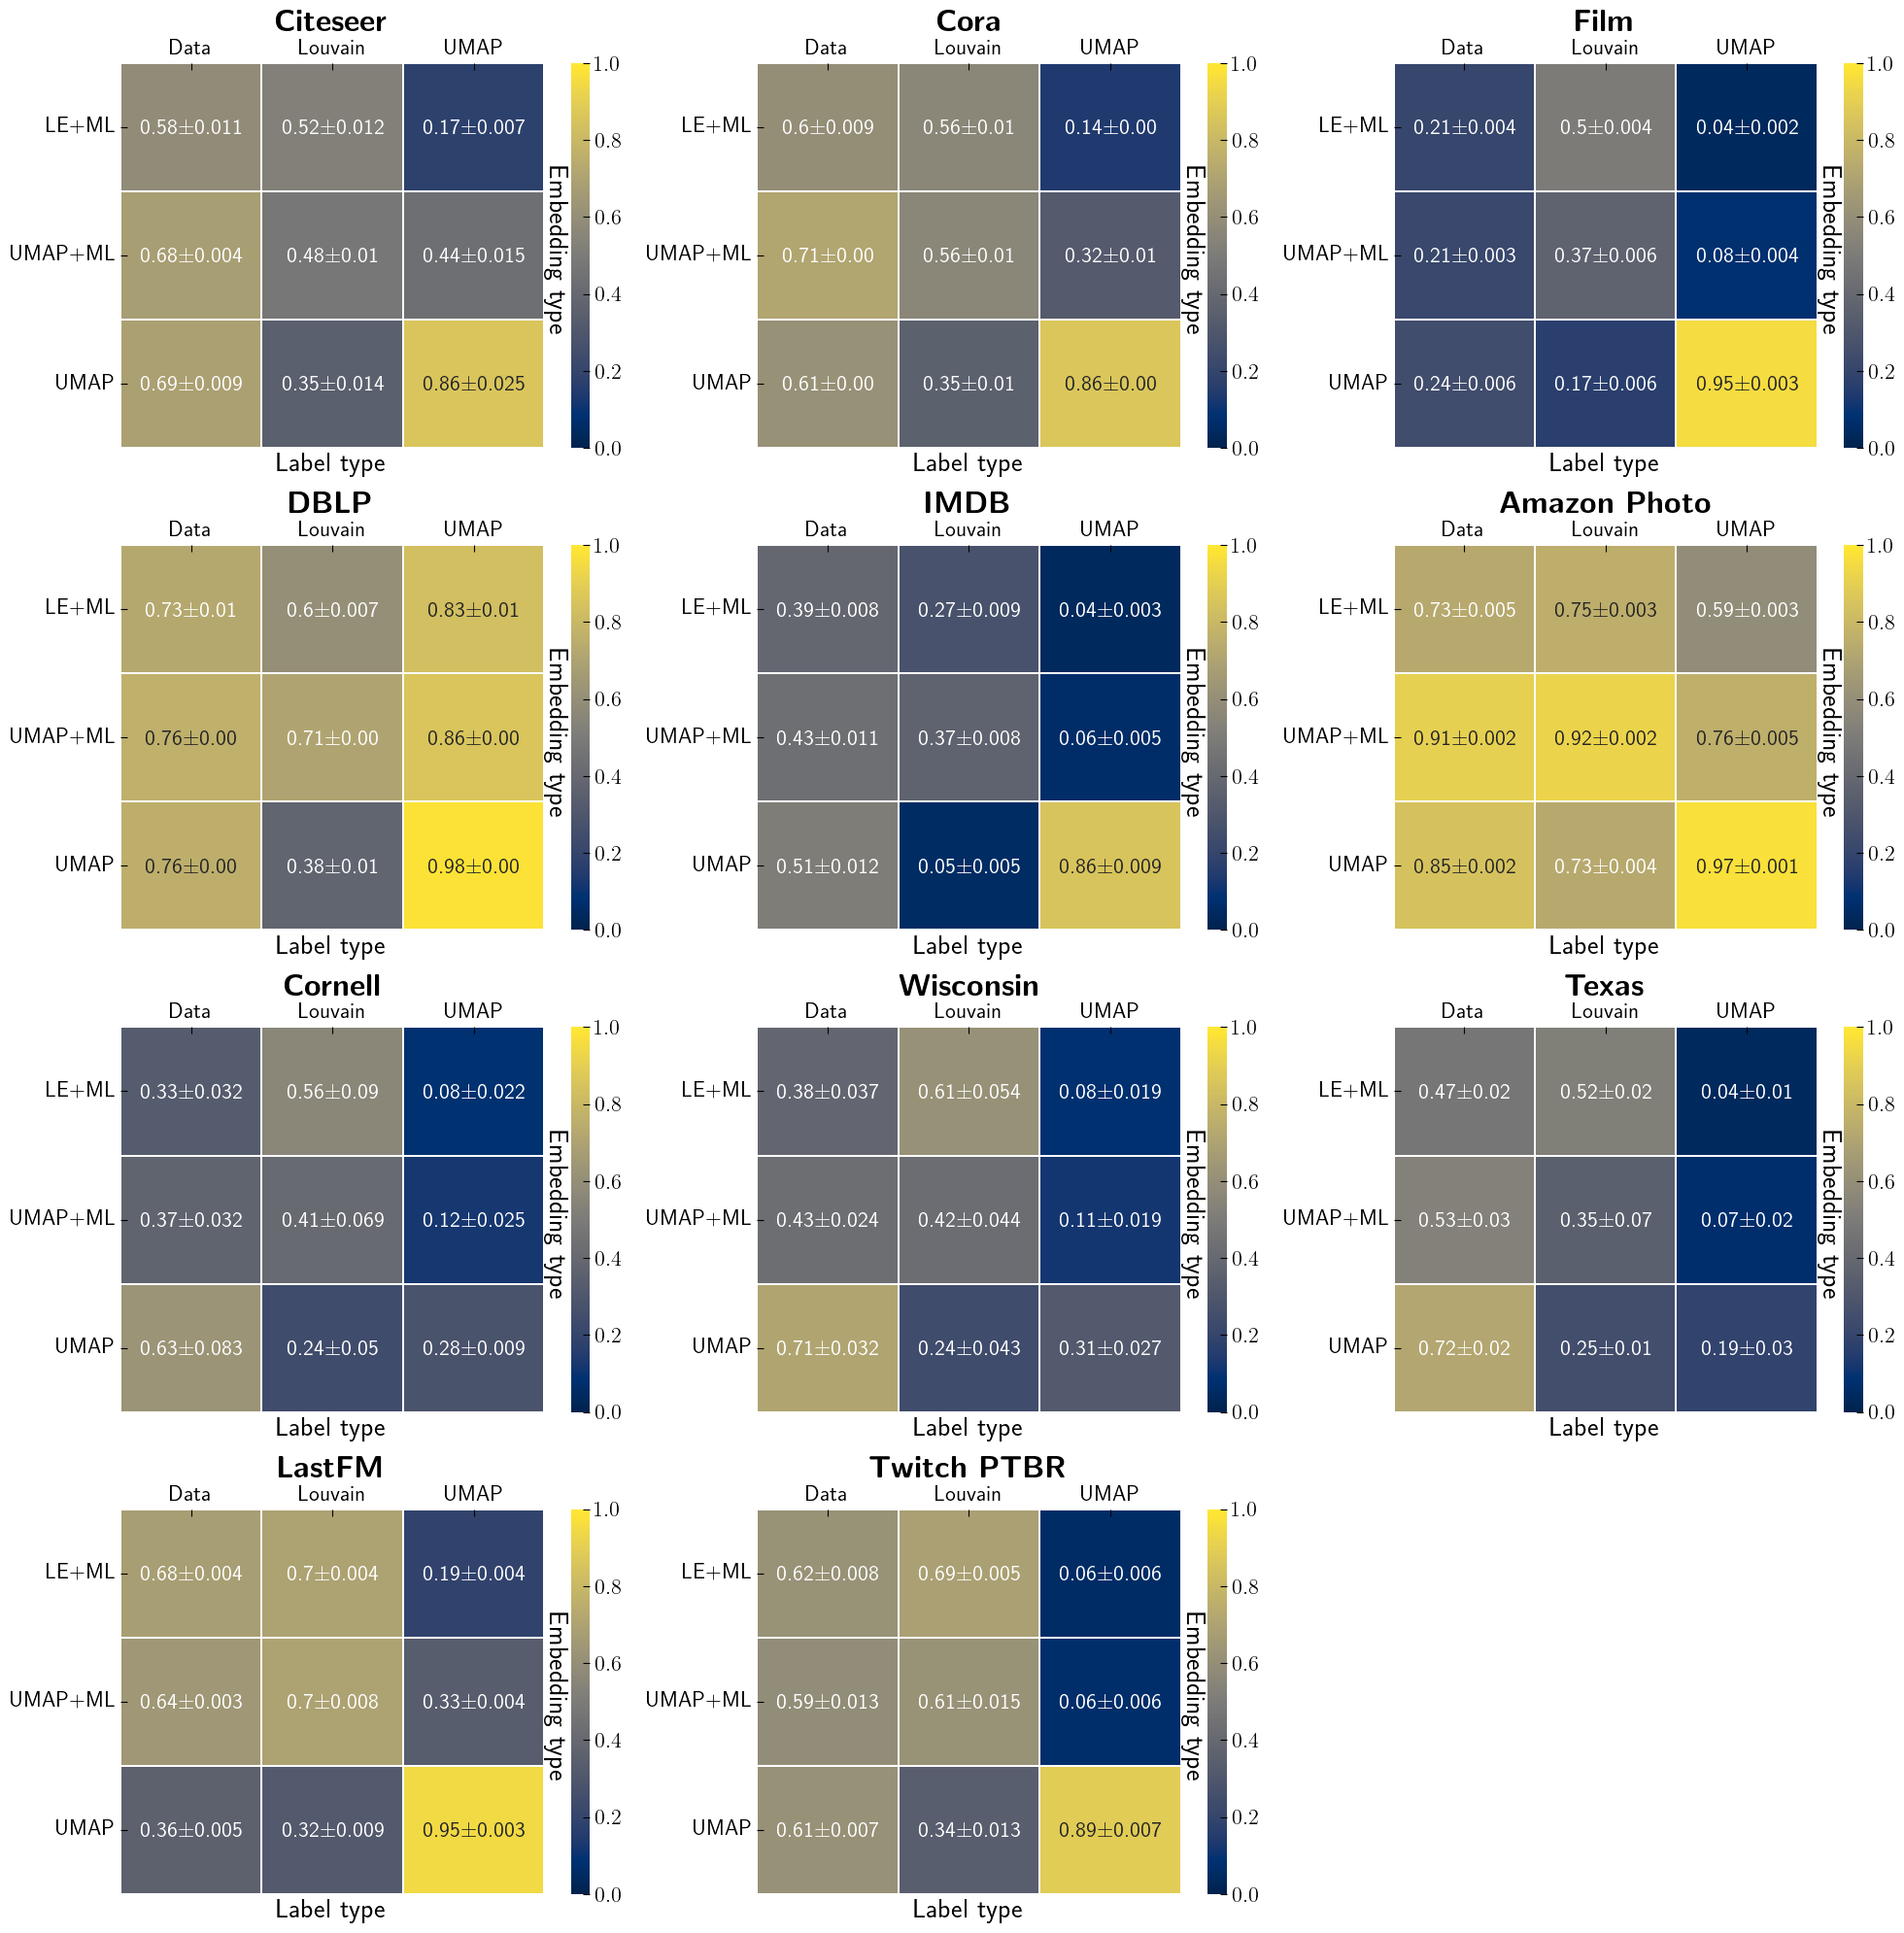

time: 5.71 s (started: 2023-03-29 14:06:09 +02:00)


In [108]:
plt.figure(figsize=(20, 20))

for i in range(11):
    plt.subplot(4, 3, i+1)
    plot_heatmap_per_dataset(i, datasets[i])

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/node-classification-different-type-of-labels-28-03-23/plots/node_classification_different_methods.pdf")